In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from transformers import DistilBertModel, DistilBertTokenizer
from PIL import Image
import os

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

class ImageEncoder(nn.Module):
    def __init__(self):
        super(ImageEncoder, self).__init__()
        self.resnet = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
        self.resnet.fc = nn.Identity()
        for param in self.resnet.parameters():
            param.requires_grad = False
        self.fc = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, 512)

    def forward(self, x):
        x = self.resnet(x)
        x = self.fc(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x
    
class TextEncoder(nn.Module):
    def __init__(self):
        super(TextEncoder, self).__init__()
        self.model = DistilBertModel.from_pretrained('distilbert-base-uncased')
        for param in self.model.parameters():
            param.requires_grad = False
        self.fc = nn.Linear(768, 768)
        self.fc2 = nn.Linear(768, 512)

    def forward(self, x):
        x = tokenizer(x, return_tensors='pt', truncation=True, max_length=128, pad_to_max_length=True).to('cuda')
        x = self.model(input_ids=x['input_ids'].view(-1, 128), attention_mask=x['attention_mask'].view(-1, 128)).last_hidden_state[:, 0, :]
        x = self.fc(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x 
    
class ImageTextEncoder(nn.Module):
    def __init__(self):
        super(ImageTextEncoder, self).__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()

    def forward(self, image, text):
        image = self.image_encoder(image)
        text = self.text_encoder(text)
        return image, text
    
class Flickr8kDataset(Dataset):
    def __init__(self):
        _ = [line.split(".jpg,") for line in open("captions.txt", "r").read().split("\n")[1:]]
        _ = [(caption[0] + ".jpg", caption[1]) for caption in _]
        self.captions = {}
        for image, caption in _:
            if image in self.captions:
                self.captions[image].append(caption)
            else:
                self.captions[image] = [caption]
        self.captions_list = []
        for image, captions in self.captions.items():
            for caption in captions:
                self.captions_list.append((image, caption))
        self.images = os.listdir("Images")
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.captions_list)

    def __getitem__(self, idx):
        image_name, caption = self.captions_list[idx]
        image = Image.open(f"Images/{image_name}")
        image = self.transform(image)
        return image.cuda(), caption

dataset = Flickr8kDataset()
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
model = ImageTextEncoder().cuda()
model.load_state_dict(torch.load("model.pth"))

d:\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Using cache found in C:\Users\conor/.cache\torch\hub\pytorch_vision_v0.6.0
d:\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [2]:
# model = ImageTextEncoder().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)

for epoch in range(3):
    losses = []
    for iteration, (images, texts) in enumerate(dataloader):
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass to get the embeddings
        image_embd, text_embd = model(images, texts)
        
        # Normalize the embeddings
        image_embd = F.normalize(image_embd, p=2, dim=1)
        text_embd = F.normalize(text_embd, p=2, dim=1)
        
        # Calculate dot product similarities
        dot_product = image_embd @ text_embd.T
        
        # Labels
        labels = torch.arange(images.size(0)).cuda()

        # Calculate loss
        loss_i = F.cross_entropy(dot_product, labels)
        loss_t = F.cross_entropy(dot_product.T, labels)
        loss = (loss_i + loss_t) / 2
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Store loss
        losses.append(loss.item())
        
        if iteration % 10 == 0:
            print(f"Epoch: {epoch}, Iteration: {iteration}, Average Loss: {sum(losses)/len(losses)}")
            losses = []

d:\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 0, Iteration: 0, Average Loss: 4.148797988891602
Epoch: 0, Iteration: 10, Average Loss: 4.14741883277893
Epoch: 0, Iteration: 20, Average Loss: 4.151135587692261
Epoch: 0, Iteration: 30, Average Loss: 4.150754690170288
Epoch: 0, Iteration: 40, Average Loss: 4.147617626190185
Epoch: 0, Iteration: 50, Average Loss: 4.155653095245361
Epoch: 0, Iteration: 60, Average Loss: 4.151304435729981
Epoch: 0, Iteration: 70, Average Loss: 4.149246025085449
Epoch: 0, Iteration: 80, Average Loss: 4.152559518814087
Epoch: 0, Iteration: 90, Average Loss: 4.145635366439819
Epoch: 0, Iteration: 100, Average Loss: 4.142484140396118
Epoch: 0, Iteration: 110, Average Loss: 4.1454555034637455
Epoch: 0, Iteration: 120, Average Loss: 4.147959852218628
Epoch: 0, Iteration: 130, Average Loss: 4.144470930099487
Epoch: 0, Iteration: 140, Average Loss: 4.1448140144348145
Epoch: 0, Iteration: 150, Average Loss: 4.138861227035522
Epoch: 0, Iteration: 160, Average Loss: 4.144157934188843
Epoch: 0, Iteration: 170

d:\anaconda3\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch: 1, Iteration: 0, Average Loss: 4.124393463134766
Epoch: 1, Iteration: 10, Average Loss: 4.140011405944824
Epoch: 1, Iteration: 20, Average Loss: 4.133336782455444
Epoch: 1, Iteration: 30, Average Loss: 4.127874088287354
Epoch: 1, Iteration: 40, Average Loss: 4.137321043014526
Epoch: 1, Iteration: 50, Average Loss: 4.141716957092285
Epoch: 1, Iteration: 60, Average Loss: 4.130444717407227
Epoch: 1, Iteration: 70, Average Loss: 4.136462211608887
Epoch: 1, Iteration: 80, Average Loss: 4.132256984710693
Epoch: 1, Iteration: 90, Average Loss: 4.1394118309021
Epoch: 1, Iteration: 100, Average Loss: 4.138817167282104
Epoch: 1, Iteration: 110, Average Loss: 4.136107492446899
Epoch: 1, Iteration: 120, Average Loss: 4.1313127994537355
Epoch: 1, Iteration: 130, Average Loss: 4.138090324401856
Epoch: 1, Iteration: 140, Average Loss: 4.1277039527893065
Epoch: 1, Iteration: 150, Average Loss: 4.137897682189942
Epoch: 1, Iteration: 160, Average Loss: 4.134943914413452
Epoch: 1, Iteration: 170,

In [3]:
from tqdm import tqdm
import matplotlib.pyplot as plt
from annoy import AnnoyIndex

model.eval()
index = AnnoyIndex(512, 'angular')

class TestingDataset(Dataset):
    def __init__(self):
        self.images = os.listdir("Images")
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(f"Images/{self.images[idx]}")
        image = self.transform(image)
        return image.cuda()

test_dataset = TestingDataset()
similarity_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

for batch_num, images in tqdm(enumerate(similarity_dataloader)):
    image_embd = model.image_encoder(images)
    image_embd = F.normalize(image_embd, p=2, dim=1)
    for i in range(image_embd.size(0)):
        index.add_item(batch_num*128+i, image_embd[i].cpu().detach().numpy())
        
index.build(10)
index.save("index.ann")

64it [00:43,  1.48it/s]


True

d:\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


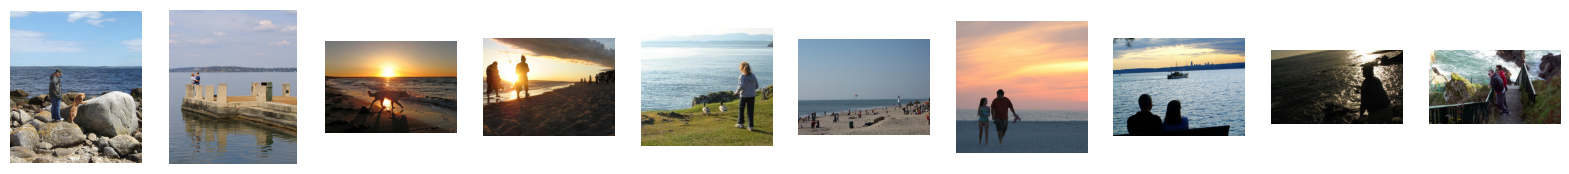

In [13]:
index = AnnoyIndex(512, 'angular')
index.load("index.ann")
text = "beautiful sunset"
text_embd = model.text_encoder(text)
similar_images = index.get_nns_by_vector(text_embd.squeeze(0).cpu().detach().numpy(), 10)
fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i, image_num in enumerate(similar_images):
    plt.subplot(1, 10, i+1)
    plt.imshow(Image.open(f"Images/{test_dataset.images[image_num]}"))
    plt.axis('off')

In [5]:
# save the model state dict
torch.save(model.state_dict(), "model.pth")